# Linear Muskingum channel routing model - constrained subcatchment calibration

## Purpose

This vignette focuses on explaining how to calibrate the linear version of Muskingum jointly across river reaches, respecting stability constraints across all these reaches. The second part of the document is an indepth explanation of the scheme that is also used as a reference for unit testing swift.

## Guidelines for global calibration of Muskingum constrainted parameters

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
import swift2

In [3]:
# Only temporary, under construction...
import swift2.wrap.swift_wrap_generated as swg
import swift2.wrap.swift_wrap_custom as swc

In [4]:
from swift2.doc_helper import *

from swift2.system import *
from swift2.simulation import *
from swift2.play_record import *
from swift2.utils import *
from swift2.parameteriser import *
from swift2.statistics import *
# from swift2.prototypes import extract_optimisation_log

from uchronia.time_series import get_item



In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from cinterop.timeseries import TIME_DIMNAME, slice_xr_time_series, pd_series_to_xr_series, slice_xr_time_series, pd_series_to_xr_series

In [7]:
from cinterop.timeseries import xr_ts_start, xr_ts_end
import datetime as dt

In [8]:
%matplotlib inline

For this example we will use data derived from the South Esk catchment in Tasmania.

## Baseline model structure

We load and configure the model simulation in the next section, without detailed explanation; please read other introductory vignettes if this is unclear.

In [9]:
model_id = 'GR4J'
site_id = 'South_Esk'
simulation = sample_catchment_model(site_id=site_id, config_id='catchment')
simulation = swap_model(simulation, 'MuskingumNonLinear', 'channel_routing')

# # revert back to derfautl values as expected from sample simulation..
# sc = 1 # reach slope in m/m
# n = 1  # default Manning's parameter value for the reach
# f = 1  # "Fudge factor" to allow for a different range of Alpha values. 
# oneHour = 1
# delt = oneHour

se_climate = sample_series(site_id=site_id, var_name='climate')
se_flows = sample_series(site_id=site_id, var_name='flow')

play_input(simulation, se_climate)
set_simulation_span(simulation, xr_ts_start(se_climate), xr_ts_end(se_climate))
set_simulation_time_step(simulation, 'hourly')
configure_hourly_gr4j(simulation)

We can get a topologic view of the model setup (albeit crowded as this is a fairly large catchment). 

(Note: may not render yet through GitHub)

In [10]:
# TODO:
# from graphviz import Digraph
# DiagrammeR(GetCatchmentDOTGraph_R(simulation))

We cookie cut to get a subcatchment near the headwaters.

In [11]:
from swift2.model_definitions import *
# from graphviz import Digraph

subsim = subset_catchment(simulation, 'node.5')
subsim

Simulation wrapper for a CFFI pointer handle to a native pointer of type id "MODEL_SIMULATION_PTR"

In [12]:
dot_graph = swg.GetCatchmentDOTGraph_py(subsim)

We configure the routing scheme to be linear (parameter N set and fixed to 1)

In [13]:
link_ids = mk_full_data_id('link', get_link_ids(subsim))
set_state_value(subsim, mk_full_data_id(link_ids, 'N'), rep(1.0, len(link_ids)))

Let's have a look at the link properties and other default routing parameters

In [14]:
lnkpnames = ['Length', 'f', 'ManningsN', 'Slope', 'N', 'X', 'Alpha']
get_state_value(subsim,mk_full_data_id('link.1', lnkpnames))

{'link.1.Length': 6140.0,
 'link.1.f': 1.0,
 'link.1.ManningsN': 1.0,
 'link.1.Slope': 1.0,
 'link.1.N': 1.0,
 'link.1.X': 0.1,
 'link.1.Alpha': 1.0}

X is between 0 and 0.5, without stability constraints. Setting a default Alpha is... trickier.

In [15]:
set_state_value(subsim, mk_full_data_id(link_ids, 'X'), rep(1e-6, len(link_ids)))
set_state_value(subsim, mk_full_data_id(link_ids, 'Alpha'), rep(0.0005, len(link_ids)))

If we look at the subcatchment outflow in this configuration, it is a series of unfeasible values - at least one link was in an unfeasible zone for (Alpha, X)

In [16]:
from swift2.const import CATCHMENT_FLOWRATE_VARID
var_id = CATCHMENT_FLOWRATE_VARID
catOutflowId = 'subarea.1.OutflowRate'

record_state(subsim,var_id)
record_state(subsim,catOutflowId)

exec_simulation(subsim)
someFlow = get_recorded(subsim, var_id)

In [17]:
someFlow.head()

<xarray.DataArray (variable_identifiers: 1, ensemble: 1, time: 5)>
array([[[0., 0., 0., 0., 0.]]])
Coordinates:
  * ensemble              (ensemble) int64 0
  * time                  (time) datetime64[ns] 2010-11-01 ... 2010-11-01T04:...
  * variable_identifiers  (variable_identifiers) object 'Catchment.Streamflow...

We can double-check that the subarea does produce runoff yield; the links are where the model does not work yet.

In [18]:
get_state_value(subsim, get_variable_ids(subsim, 'node.5'))

{'node.5.InflowRate': 7.942047038196456e-05,
 'node.5.InflowVolume': 0.28591369337507244,
 'node.5.AdditionalInflowRate': 0.0,
 'node.5.OutflowRate': 7.942047038196456e-05,
 'node.5.OutflowVolume': 0.28591369337507244}

In [19]:
get_recorded(subsim, catOutflowId).head()

<xarray.DataArray (variable_identifiers: 1, ensemble: 1, time: 5)>
array([[[0., 0., 0., 0., 0.]]])
Coordinates:
  * ensemble              (ensemble) int64 0
  * time                  (time) datetime64[ns] 2010-11-01 ... 2010-11-01T04:...
  * variable_identifiers  (variable_identifiers) object 'subarea.1.OutflowRate'

So, given that each routing link parameters Alpha and X are subject to constraint that vary depending on 'Length', 'f', 'ManningsN', 'Slope', how do we get a pair (Alpha, X) that globaly respect these constraints? This is not complex science but complicated enough to get wrong.

'swift' offers facilities to remove the error prone tedium. First, `feasibleMuskingumBounds` lists the extremas of the feasible (Alpha, X) parameter space.

In [20]:
akbounds = feasible_muskingum_bounds(subsim, 1)
akbounds

{'min_alpha': 0.08143322475570032,
 'max_x': 0.37382039573820397,
 'alpha_for_max_x': 0.13004771187286124}

The numbers above can play a *crucial* role when setting up an optimiser for this model; more on this soon.

In [21]:

oneHour = 1

pSpecMusk = pd.DataFrame(dict(Name = ['X', 'Alpha'],
  Value = [akbounds['max_x'] / 2, akbounds['alpha_for_max_x']],
  Min= [1.0E-06, akbounds['min_alpha']],   
  Max = [akbounds['max_x'], 1e5]) 
)

# Basic parameteriser
def pzm(simulation, pSpecs=pSpecMusk):
    akbounds = feasible_muskingum_bounds(simulation, 1)
    p_musk = create_parameteriser('generic links',pSpecs)
    return p_musk

# Wrapper parameteriser, with constraints added around.
def pzc(simulation, pSpecs=pSpecMusk):
    p_musk = pzm(simulation, pSpecs)
    p_musk_c = create_muskingum_param_constraints(p_musk, oneHour, "Alpha", "X", simulation)
    return p_musk_c


pp = parameteriser_as_dataframe

In [22]:
pp(pzm(subsim))

,Name,Value,Min,Max
0,X,0.186910,0.000001,0.37382
1,Alpha,0.130048,0.081433,100000.00000


In [23]:
p = pzc(subsim)
pp(p)

,Name,Value,Min,Max
0,X,0.186910,0.000001,0.373820
1,Alpha,0.130048,0.100153,0.260095


Let's get a trace of the subcatchment outflow, as a synthetic data to calibrated against.

In [24]:
apply_sys_config(p, subsim)
exec_simulation(subsim)
someFlow = get_recorded(subsim, var_id)

In [25]:
someFlow.to_series().describe()

count    4.800000e+02
mean     6.164971e-03
std      2.694368e-02
min      0.000000e+00
25%      8.691205e-07
50%      8.687524e-05
75%      6.349944e-04
max      2.682614e-01
dtype: float64

We do now get a valid outflow since (Alpha-K) respects feasibility constraints on all links.

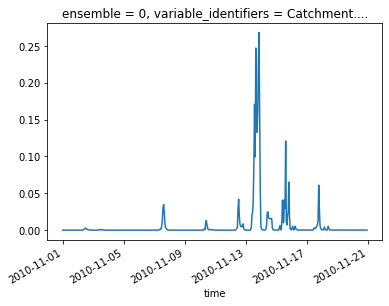

In [26]:
someFlow.plot();

## Setting up calibration

In [27]:
def c(*args):
    return np.array([x for x in args])

pSpecMaxBounds = pd.DataFrame(dict(
  Name =  c('X',     'Alpha'),
  Value = c(1.0E-6, akbounds['alpha_for_max_x']), # IMPORTANT to use these values.
  Min=    c(1.0E-6, akbounds['min_alpha']),   
  Max =   c(akbounds['max_x'], 1e6), # Alpha_max can get very large. 
)
                             )
pp(pzc(subsim, pSpecMaxBounds))

,Name,Value,Min,Max
0,X,0.000001,0.000001,0.373820
1,Alpha,0.130048,0.081433,48614.487117


If we were to use another (X, Alpha) point e.g. X=0.1869102, the feasible bounds for Alpha change drastically. If an optimiser samples this for an initial population of points (SCE), this is unnecessarily restrictive for Alpha. Many hydrological calibration schemes were designed without consideration on feasible space that are not hypercubes.

In [28]:
pp(pzc(subsim, pSpecMusk))

,Name,Value,Min,Max
0,X,0.186910,0.000001,0.373820
1,Alpha,0.130048,0.100153,0.260095


While calibrating in the (Alpha,X) space is possible, perhaps preferable in some cases, (1/Alpha,X) has a triangular shaped feasibility region that may be easier to handle for optimisers that work with geometric transformation in the parameter space (SCE). Swift can add this on top of the constrained calibration:

In [29]:
# (X, 1/Alpha) parametrizer with dynamically constrained min/max bounds.
def pzer_inv(simulation, pSpecs=pSpecMusk):
    p_musk_c = pzc(simulation, pSpecs)
    p_musk_inv_a = wrap_transform(p_musk_c)
    add_transform(p_musk_inv_a, 'inv_alpha', 'Alpha', '1/x')
    return p_musk_inv_a

p = pzer_inv(subsim, pSpecMaxBounds)
pp(p)

,Name,Value,Min,Max
0,inv_alpha,7.689486,0.000021,12.279988
1,X,0.000001,0.000001,0.373820


We check that backtransforming to (Alpha-X) works:

In [30]:
pp(backtransform(p))

,Name,Value,Min,Max
0,X,0.000001,0.000001,0.373820
1,Alpha,0.130048,0.081433,48614.487117


In [31]:
someFlow = someFlow.squeeze()

In [32]:
objectiveId = 'NSE'
objective = create_objective(subsim, var_id, someFlow, objectiveId, xr_ts_start(someFlow), xr_ts_end(someFlow))

In [33]:
score = get_score(objective,p)  
score

{'scores': {'NSE': 0.9997748469565144},
 'sysconfig':         Name     Value       Min        Max
 0  inv_alpha  7.689486  0.000021  12.279988
 1          X  0.000001  0.000001   0.373820}

In [34]:
#termination = swift::CreateSceMaxRuntimeTerminationWila_R(1/60)
termination = create_sce_termination_wila('relative standard deviation', c('0.001','0.0167'))
npars = 2
sce_params = sce_parameter(npars)
optimiser = create_sce_optim_swift(objective,termination_criterion = termination, population_initialiser = p,sce_params = sce_params)
calib_logger = set_calibration_logger(optimiser,"dummy")

In [35]:
%%time
calib_results = execute_optimisation(optimiser)

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 371 ms


In [36]:
opt_log = optimiser.extract_optimisation_log(fitness_name = "NSE")

In [37]:
from swift2.vis import OptimisationPlots
shuffleLogs = opt_log['data'].subset_by_message(pattern = "Initial.*|Shuffling.*") 
shuffleLogs

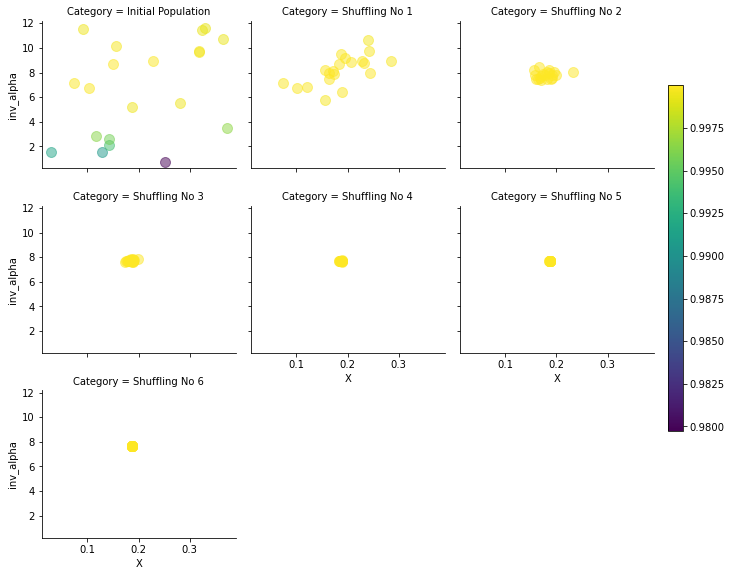

In [38]:
v = OptimisationPlots(shuffleLogs)
g = v.shuffles('X', 'inv_alpha', obj_lims = [0.0,1.0])
plt.gcf().set_size_inches(10,8)

In [39]:
sortedResults = sort_by_score(calib_results, 'NSE')
scores_as_dataframe(sortedResults).head()

,NSE,inv_alpha,X
0,1.0,7.689032,0.186874
1,1.0,7.690300,0.186925
2,1.0,7.690382,0.186887
3,1.0,7.690224,0.186842
4,1.0,7.689243,0.186813


In [40]:
q = get_best_score(calib_results, 'NSE', False)
q = swg.GetSystemConfigurationWila_py(q)
pp(q)

,Name,Value,Min,Max
0,inv_alpha,7.689032,3.844007,9.985182
1,X,0.186874,0.000001,0.373798


In [41]:
pp(backtransform(q))

,Name,Value,Min,Max
0,X,0.186874,0.000001,0.373798
1,Alpha,0.130055,0.100148,0.260145


## Seeding the optimisation point population with restrictive constraint bounds

This section is a *counter-example*. Do not do this.

Say, instead of seeding with alpha set to alpha_for_x_max (0.37382040) we instead use a value close to its global minimum, 0.083:

In [42]:
pSpecRestrictiveBounds = pSpecMaxBounds

pSpecRestrictiveBounds.loc[pSpecRestrictiveBounds.Name == 'Alpha', 'Value'] = 0.083

In [43]:
pSpecRestrictiveBounds

,Name,Value,Min,Max
0,X,0.000001,0.000001,0.37382
1,Alpha,0.083000,0.081433,1000000.00000


In [44]:
p = pzer_inv(subsim, pSpecRestrictiveBounds)
pp(p)

,Name,Value,Min,Max
0,inv_alpha,12.048193,0.000021,12.279988
1,X,0.000001,0.000001,0.018877


X is now much more constrained in its feasible range, and initializing a population fails to cover large sections of the feasible triangle. If used in the optimiser (uniform random sampling)


In [45]:
termination = create_sce_termination_wila('relative standard deviation', c('0.001','0.0167'))
sce_params = get_default_sce_parameters()
npars = 2
sce_params = sce_parameter(npars)
optimiser = create_sce_optim_swift(objective,termination_criterion = termination, population_initialiser = p,sce_params = sce_params)
calib_logger = set_calibration_logger(optimiser,"dummy")
calib_results = execute_optimisation(optimiser)

In [46]:
opt_log = extract_optimisation_log(optimiser, fitness_name = "NSE")

In [47]:
shuffleLogs = opt_log['data'].subset_by_message(pattern = "Initial.*|Shuffling.*") 



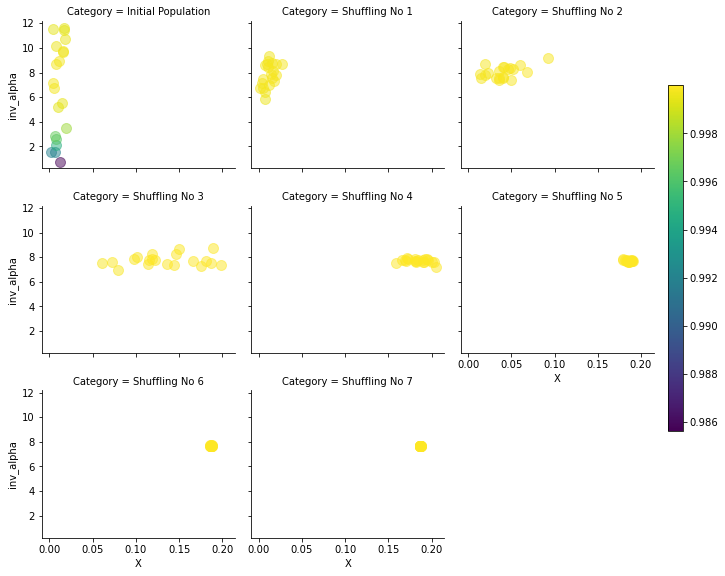

In [48]:
v = OptimisationPlots(shuffleLogs)
g = v.shuffles('X', 'inv_alpha', obj_lims = [0.0,1.0])
plt.gcf().set_size_inches(10,8)

In [49]:
# shuffleLogs = mhplot::subsetByCategory(opt_log$data, pattern = "Initial.*|Shuffling.*") 
# mhplot::plotShuffles(shuffleLogs, 'X', 'inv_alpha', obj_lims = (0:1))

SCE does manage to converge towards the optimum, but it takes a larger number of iterations. Anecdotally, we observed cases where the calibration does fail to go near the optimum, when interplaying with a convergence criterion configured for "leniency".

# Detailed explanation and unit test design

See other document [muskingum_multilink_calibration_explanation.ipynb](./muskingum_multilink_calibration_explanation.ipynb)
